# Lasso- и Ridge-регрессия

За материал спасибо команде [ODS](https://habr.com/company/ods/blog/323890/).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

**Будем работать с набором данных по ценам на дома в Бостоне (репозиторий UCI).**
**Загружаем данные.**

In [2]:
boston = load_boston()
X, y = boston['data'], boston['target']

**Почитаем описание набора данных:**

In [3]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

**Признаки:**
- CRIM - количество преступлений на душу населения
- ZN - процент жилых участков площадью больше 25 тыс. кв. футов (~ 23 сотки)
- INDUS - процент площадей под оптовую торговлю 
- CHAS - протекает ли река
- NOX - концентрация оксидов азота
- RM - среднее число комнат в здании
- AGE - доля зданий, построенных до 1940 года 
- DIS - взвешенное расстояние до 5 деловых центров Бостона
- RAD - индекс доступности скоростных магистралей
- TAX - уровень налогов
- PTRATIO - среднее число учащихся на одного преподавателя 
- B - процент афроамериканцев
- LSTAT - процент граждан с низким уровнем жизни
- MEDV (целевой) - медианная стоимости домов в районе

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

**Посмотрим на первые 2 записи.**

In [5]:
X[:2]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00]])

## Lasso-регрессия

Lasso-регрессия решает задачу минимизации среднеквардатичной ошибки с L1-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d |w_i|$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

**Обучим Lasso-регрессию с небольшим коэффициентом $\alpha$ (слабая регуляризация). Обнуляется только коэффициент при признаке NOX (концентрация оксидов азота). Значит, он наименее важен для предсказания целевого признака – медианной стоимости домов в районе.**

In [6]:
lasso = Lasso(alpha=0.1)
lasso.fit(X,y)
for col in list(zip(boston.feature_names, lasso.coef_)):
    print('{:7} {:7.4f}'.format(col[0], col[1]))

CRIM    -0.0968
ZN       0.0492
INDUS   -0.0364
CHAS     0.9571
NOX     -0.0000
RM       3.6989
AGE     -0.0100
DIS     -1.1601
RAD      0.2741
TAX     -0.0146
PTRATIO -0.7710
B        0.0103
LSTAT   -0.5695


**Обучим Lasso-регрессию с коэффициентом $\alpha=10$. Теперь ненулевые коэффициенты остались только при признаках ZN (процент жилых участков площадью больше 25 тыс. кв. футов), TAX (уровень налогов), B (процент афроамериканцев) и LSTAT (процент граждан с низким уровнем жизни).**

In [7]:
lasso = Lasso(alpha=10)
lasso.fit(X, y)
for col in list(zip(boston.feature_names, lasso.coef_)):
    print('{:7} {:7.4f}'.format(col[0], col[1]))

CRIM    -0.0000
ZN       0.0261
INDUS   -0.0000
CHAS     0.0000
NOX      0.0000
RM       0.0000
AGE      0.0000
DIS     -0.0000
RAD      0.0000
TAX     -0.0093
PTRATIO -0.0000
B        0.0075
LSTAT   -0.5640


**Таким образом, Lasso-регрессия служит методом отбора признаков.**

**Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации.**

In [10]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)

In [12]:
lasso_cv = LassoCV(alphas=alphas, 
                   cv=3, random_state=17)
lasso_cv.fit(X, y)

LassoCV(alphas=array([ 0.1    ,  0.14975, ...,  9.95025, 10.     ]),
    copy_X=True, cv=3, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=17, selection='cyclic', tol=0.0001,
    verbose=False)

In [13]:
lasso_cv.coef_

array([-0.09633634,  0.04943349, -0.02730583,  0.16245012, -0.        ,
        3.55546459, -0.00723939, -1.13353947,  0.28039514, -0.0150312 ,
       -0.78020119,  0.01032709, -0.58332373])

In [14]:
lasso_cv.alpha_

0.14974874371859298

**Метод `cross_val_score` максимизирует метрику, так что вместо 
минимизации MSE сделаем максимизацию отрицательного MSE – `neg_mean_squared_error`.**

In [17]:
cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=5, 
                scoring='neg_mean_squared_error')

array([-11.36431027, -24.39923863, -31.29513739, -77.63368796,
       -29.69388075])

**Чтобы все-таки трактовать результат в терминах MSE, выведем модуль среднего значения метрики `neg_mean_squared_error` на кросс-валидации.**

In [20]:
abs(np.mean(cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=5, 
                        scoring='neg_mean_squared_error')))

34.87725099918953

In [23]:
abs(np.mean(cross_val_score(Lasso(9.95), X, y, cv=10 , 
                            scoring='neg_mean_squared_error')))

45.81915546165962

**Еще один неоднозначный момент: LassoCV сортирует значения параметров по убыванию – так проще оптимизировать. Из-за этого может показаться, что оптимизация параметра $\alpha$ работает неправильно**

In [24]:
lasso_cv.alphas[:10] # значения параметров на входе

array([0.1       , 0.14974874, 0.19949749, 0.24924623, 0.29899497,
       0.34874372, 0.39849246, 0.44824121, 0.49798995, 0.54773869])

In [25]:
lasso_cv.alphas_[:10] # преобразованные значения параметров

array([10.        ,  9.95025126,  9.90050251,  9.85075377,  9.80100503,
        9.75125628,  9.70150754,  9.65175879,  9.60201005,  9.55226131])

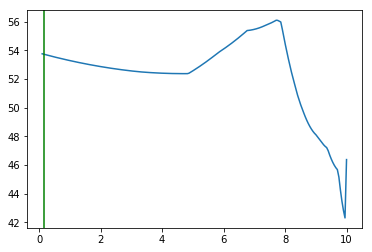

In [26]:
plt.plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1)) # неверно
plt.axvline(lasso_cv.alpha_, c='g');

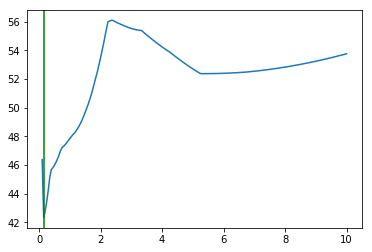

In [27]:
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1)) # верно
plt.axvline(lasso_cv.alpha_, c='g');

## Ridge-регрессия

Ridge-регрессия (или гребневая регрессия) решает задачу минимизации среднеквардатичной ошибки с L2-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d w_i^2$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

В sklearn реализован специальный класс [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для кросс-валидации с Ridge-регрессией.

In [28]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

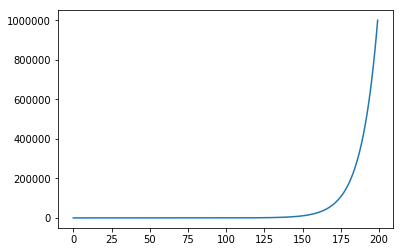

In [30]:
plt.plot(ridge_alphas)

In [31]:
ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

RidgeCV(alphas=array([1.00000e-02, 1.09699e-02, ..., 9.11589e+05, 1.00000e+06]),
    cv=3, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [32]:
ridge_cv.alpha_

264.30814869741084

**В случае Ridge-регрессии никакие праметры не зануляются – они могут быть очень малыми, но не нулевыми.**

In [33]:
ridge_cv.coef_

array([-0.0992728 ,  0.05560678, -0.04988281,  0.30212213, -0.09167075,
        1.42147115,  0.01290084, -0.99854933,  0.33047941, -0.01661163,
       -0.82006053,  0.00883866, -0.72358474])

In [36]:
abs(np.mean(cross_val_score(Ridge(ridge_cv.alpha_), X, y, cv=5, 
                        scoring='neg_mean_squared_error')))

30.04636750182353

In [37]:
abs(np.mean(cross_val_score(Ridge(10), X, y, cv=5, 
                        scoring='neg_mean_squared_error')))

33.45785824211423

## Ссылки
- [Обощеннные линейные модели](http://scikit-learn.org/stable/modules/linear_model.html) (Generalized Linear Models, GLM) в Scikit-learn
- [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV), [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) и [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) в Scikit-learn
- [Статья](https://habrahabr.ru/post/264915/) "Методы отбора фич" на Хабрахабре с упоминанием Lasso-регрессии 